In [19]:
import iris
from iris.experimental.equalise_cubes import equalise_attributes
import iris.quickplot as qp
import matplotlib.pyplot as plt
import itertools
import pandas

from scipy.stats import percentileofscore

import warnings
warnings.filterwarnings('ignore')

In [6]:
## Define parameters to filter files
set_experiment = 'rcp85'
# path to files with climate change signal
set_path = 'data' 
set_season = 'annual'
# near, mid or far (future)
set_time = 'far' 

# select bounding box
set_lat = (42.2, 46.2)
set_lon = (18.9, 23.0)

In [7]:
realization = 0
choose_time = {'near': "2021-2050",
               'mid': "2036-2065",
               'far': "2070-2099"}

In [8]:
def lagged_ensemble_callback(cube, field, filename):
    # Add our own realization coordinate if it doesn't already exist.
    if not cube.coords('realization'):
        global realization 
        realization += 1
        ensemble_coord = iris.coords.AuxCoord(realization, standard_name='realization')
        cube.add_aux_coord(ensemble_coord)

In [9]:
cl_pr = iris.load_raw("../ccs_corr/ccs_pr_{}_*{}_*_{}.nc".format(set_season, set_experiment, choose_time[set_time]), 
                      callback=lagged_ensemble_callback)

In [10]:
cl_tas =  iris.load_raw("../ccs_corr/ccs_tasmax_{}_*{}_*_{}.nc".format(set_season, set_experiment, choose_time[set_time]), 
                      callback=lagged_ensemble_callback)

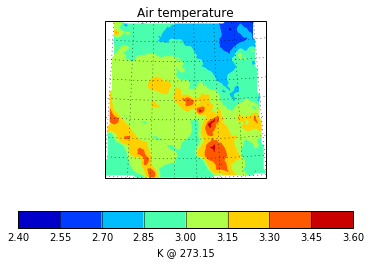

In [11]:
qp.contourf(cl_tas[0][0,:,:])
ax = plt.gca()
ax.gridlines()
qp.show()

In [12]:
for i in range(len(cl_pr)):
    cl_pr[i] = cl_pr[i].intersection(grid_latitude=(-6,-5), grid_longitude=(2, 3)
                                    ).collapsed(['grid_latitude','grid_longitude'],iris.analysis.MEAN)
    cl_tas[i] = cl_tas[i].intersection(grid_latitude=(-6,-5), grid_longitude=(2, 3)
                                      ).collapsed(['grid_latitude','grid_longitude'],iris.analysis.MEAN)

In [13]:
ls_models_tas = [c_tas.attributes['model'] for c_tas in cl_tas]
ls_models_pr = [c_tas.attributes['model'] for c_tas in cl_tas]

In [14]:
ls_models_tas == ls_models_pr

True

In [15]:
equalise_attributes(cl_pr)
equalise_attributes(cl_tas)

In [16]:
cl_pr_merge = cl_pr.merge_cube()
cl_tas_merge = cl_tas.merge_cube()

In [17]:
cl_tas_merge

<iris 'Cube' of air_temperature / (degree_Celsius) (realization: 16; time: 1)>

In [22]:
ccs_series_pr = pandas.Series(cl_pr_merge.data[:,0], index = ls_models_pr, name="ccs_pr")
ccs_series_tas = pandas.Series(cl_tas_merge.data[:,0], index = ls_models_tas, name="ccs_tas")

In [24]:
ccs_perc_pr = pandas.Series(ccs_series_pr.rank(pct=True)*100, name="percentiles")
ccs_perc_tas = pandas.Series(ccs_series_tas.rank(pct=True)*100, name="percentiles")

In [25]:
pd_df_pr = pandas.concat([ccs_series_pr, ccs_perc_pr], axis=1)
pd_df_tas = pandas.concat([ccs_series_tas, ccs_perc_tas], axis=1)

In [26]:
pd_df_pr.sort_values("percentiles")

,ccs_pr,percentiles
MPI-M-MPI-ESM-LR_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1,-3.771723,6.25
MOHC-HadGEM2-ES_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1,-1.955711,12.50
MPI-M-MPI-ESM-LR_rcp85_r1i1p1_MPI-CSC-REMO2009_v1,1.971074,18.75
IPSL-IPSL-CM5A-MR_rcp85_r1i1p1_SMHI-RCA4_v1,3.439654,25.00
ICHEC-EC-EARTH_rcp85_r12i1p1_KNMI-RACMO22E_v1,3.450866,31.25
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_SMHI-RCA4_v1,5.132025,37.50
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1,5.676598,43.75
NCC-NorESM1-M_rcp85_r1i1p1_DMI-HIRHAM5_v2,5.784793,50.00
ICHEC-EC-EARTH_rcp85_r1i1p1_KNMI-RACMO22E_v1,6.496072,56.25
MPI-M-MPI-ESM-LR_rcp85_r2i1p1_MPI-CSC-REMO2009_v1,8.390728,62.50


In [27]:
pd_df_tas.sort_values("percentiles")

,ccs_tas,percentiles
NCC-NorESM1-M_rcp85_r1i1p1_DMI-HIRHAM5_v2,2.752495,6.25
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1,2.755240,12.50
ICHEC-EC-EARTH_rcp85_r12i1p1_CLMcom-CCLM4-8-17_v1,2.843318,18.75
ICHEC-EC-EARTH_rcp85_r3i1p1_DMI-HIRHAM5_v1,3.171101,25.00
MPI-M-MPI-ESM-LR_rcp85_r2i1p1_MPI-CSC-REMO2009_v1,3.326051,31.25
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_SMHI-RCA4_v1,3.352316,37.50
MPI-M-MPI-ESM-LR_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1,3.584966,43.75
IPSL-IPSL-CM5A-MR_rcp85_r1i1p1_IPSL-INERIS-WRF331F_v1,3.672141,50.00
ICHEC-EC-EARTH_rcp85_r1i1p1_KNMI-RACMO22E_v1,3.699764,56.25
MPI-M-MPI-ESM-LR_rcp85_r1i1p1_MPI-CSC-REMO2009_v1,3.804420,62.50


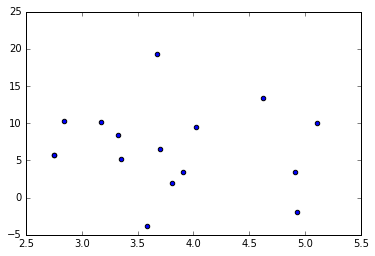

In [28]:
plt.scatter(ccs_series_tas,ccs_series_pr)